# Bayesian Statistics with Python
### For the things we have to learn before we can do them, we learn by doing them --- Aristotle, The Nicomachean Ethics
Edited by [Jiaming Mei](www.meijiaming.com), Refer to [Susan Li](https://towardsdatascience.com/hands-on-bayesian-statistics-with-python-pymc3-arviz-499db9a59501)

## The Data

Since I am interested in using machine learning for price optimization, I decide to apply Bayesian methods to [a Spanish High Speed Rail tickets pricing data set](https://raw.githubusercontent.com/susanli2016/Machine-Learning-with-Python/master/data/renfe_small.csv) that can be found here. Appreciate The [Gurus team](https://thegurus.tech/) for scraping the data set.

In [1]:
from scipy import stats
import arviz as az
import numpy as np
import matplotlib.pyplot as plt
import pymc3 as pm
import seaborn as sns
import pandas as pd
from theano import shared
from sklearn import preprocessing
print('Running on PyMC3 v{}'.format(pm.__version__))
data = pd.read_csv('renfe.csv')
data.drop('Unnamed: 0', axis = 1, inplace=True)
data = data.sample(frac=0.01, random_state=99)
data.head(6)

Running on PyMC3 v3.7


,insert_date,origin,destination,start_date,end_date,train_type,price,train_class,fare
420104,2019-04-22 08:00:25,MADRID,SEVILLA,2019-04-28 08:30:00,2019-04-28 11:14:00,ALVIA,NaN,Turista,Flexible
431888,2019-04-22 10:03:24,MADRID,VALENCIA,2019-05-20 06:45:00,2019-05-20 08:38:00,AVE,21.95,Turista,Promo
791293,2019-04-25 19:19:46,MADRID,SEVILLA,2019-05-29 06:20:00,2019-05-29 09:16:00,AV City,38.55,Turista,Promo
678876,2019-04-24 06:21:57,SEVILLA,MADRID,2019-05-03 08:35:00,2019-05-03 15:26:00,LD-MD,34.35,Turista con enlace,Promo +
86381,2019-04-19 21:13:55,VALENCIA,MADRID,2019-05-10 09:40:00,2019-05-10 11:20:00,AVE,45.30,Turista,Promo
1775485,2019-04-13 14:05:18,MADRID,BARCELONA,2019-04-15 19:30:00,2019-04-15 22:40:00,AVE,85.10,Turista,Promo


In [8]:
print(data.isnull().head(6))
print(data.isnull().sum())
print(len(data))
data.isnull().sum()/len(data)

         insert_date  origin  destination  start_date  end_date  train_type  \
420104         False   False        False       False     False       False   
431888         False   False        False       False     False       False   
791293         False   False        False       False     False       False   
678876         False   False        False       False     False       False   
86381          False   False        False       False     False       False   
1775485        False   False        False       False     False       False   

         price  train_class   fare  
420104    True        False  False  
431888   False        False  False  
791293   False        False  False  
678876   False        False  False  
86381    False        False  False  
1775485  False        False  False  
insert_date       0
origin            0
destination       0
start_date        0
end_date          0
train_type        0
price          3082
train_class     103
fare            103
dtype: 

insert_date    0.000000
origin         0.000000
destination    0.000000
start_date     0.000000
end_date       0.000000
train_type     0.000000
price          0.119467
train_class    0.003993
fare           0.003993
dtype: float64

There are 12% of values in price column are missing, I decide to fill them with the mean of the respective fare types. Also fill the other two categorical columns with the most common values.

In [9]:
data['train_class'] = data['train_class'].fillna(data['train_class'].mode().iloc[0])
data['fare'] = data['fare'].fillna(data['fare'].mode().iloc[0])
data['price'] = data.groupby('fare').transform(lambda x: x.fillna(x.mean()))

##  Gaussian Inferences

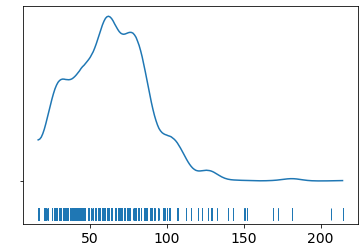

In [12]:
az.plot_kde(data['price'].values, rug=True)
plt.yticks([0], alpha=0);

The KDE plot of the rail ticket price shows a Gaussian-like distribution, except for about several dozens of data points that are far away from the mean.
Let’s assume that a Gaussian distribution is a proper description of the rail ticket price. Since we do not know the mean or the standard deviation, we must set priors for both of them. Therefore, a reasonable model could be as follows.
* μ, mean of a population. Normal distribution, very wide. I do not know the possible values of μ, I can set priors reflecting my ignorance. From experience I know that train ticket price can not be lower than 0 or higher than 300, so I set the boundaries of the uniform distribution to be 0 and 300. You may have different experience and set the different boundaries. That is totally fine. And if you have more reliable prior information than I do, please use it!
* σ, standard deviation of a population. Can only be positive, therefore use HalfNormal distribution. Again, very wide.

In [13]:
with pm.Model() as model_g:
    μ = pm.Uniform('μ', lower=0, upper=300)
    σ = pm.HalfNormal('σ', sd=10)
    y = pm.Normal('y', mu=μ, sd=σ, observed=data['price'].values)
    trace_g = pm.sample(1000, tune=1000)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [σ, μ]
Sampling 4 chains: 100%|██████████| 8000/8000 [00:04<00:00, 1707.74draws/s]


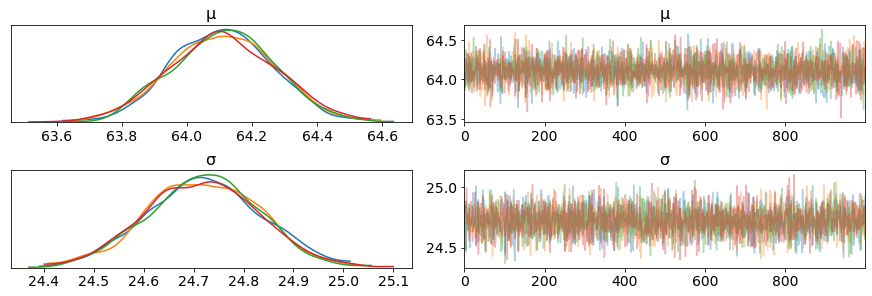

In [14]:
az.plot_trace(trace_g);

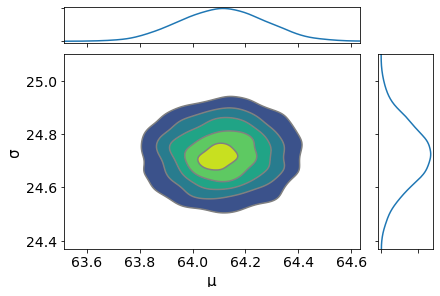

In [15]:
az.plot_joint(trace_g, kind='kde', fill_last=False);

In [16]:
az.summary(trace_g)

,mean,sd,hpd_3%,hpd_97%,mcse_mean,mcse_sd,ess_mean,ess_sd,ess_bulk,ess_tail,r_hat
μ,64.110,0.157,63.825,64.403,0.002,0.002,4274.0,4274.0,4263.0,2924.0,1.0
σ,24.719,0.111,24.510,24.926,0.002,0.001,3924.0,3924.0,3916.0,2876.0,1.0


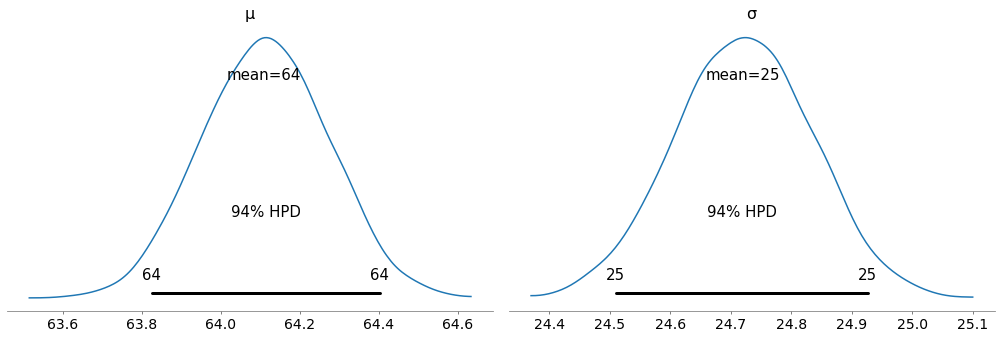

In [17]:
az.plot_posterior(trace_g);

In [18]:
pm.gelman_rubin(trace_g)

{'μ': 0.9997092906277232, 'σ': 0.9996277315840837}

## Posterior Predictive Checks

* Posterior predictive checks (PPCs) are a great way to validate a model. The idea is to generate data from the model using parameters from draws from the posterior.
* Now that we have computed the posterior, we are going to illustrate how to use the simulation results to derive predictions.
* The following function will randomly draw 1000 samples of parameters from the trace. Then, for each sample, it will draw 25798 random numbers from a normal distribution specified by the values of μ and σ in that sample.

In [19]:
ppc = pm.sample_posterior_predictive(trace_g, samples=1000, model=model_g)
np.asarray(ppc['y']).shape

100%|██████████| 1000/1000 [00:01<00:00, 519.87it/s]


(1000, 25798)

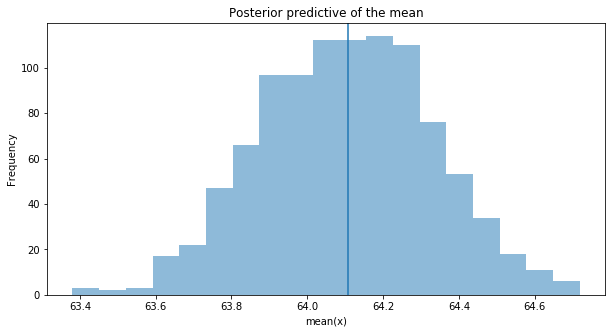

In [20]:
_, ax = plt.subplots(figsize=(10, 5))
ax.hist([y.mean() for y in ppc['y']], bins=19, alpha=0.5)
ax.axvline(data.price.mean())
ax.set(title='Posterior predictive of the mean', xlabel='mean(x)', ylabel='Frequency');

## Group Comparison

We may be interested in how price compare under different fare types. We are going to focus on estimating the effect size, that is, quantifying the difference between two fare categories. To compare fare categories, we are going to use the mean of each fare type. Because we are Bayesian, we will work to obtain a posterior distribution of the differences of means between fare categories.We create three variables:
* The price variable, representing the ticket price.
* The idx variable, a categorical dummy variable to encode the fare categories with numbers.
* And finally the groups variable, with the number of fare categories (6)

In [21]:
price = data['price'].values
idx = pd.Categorical(data['fare'],
                     categories=['Flexible', 'Promo', 'Promo +', 'Adulto ida', 'Mesa', 'Individual-Flexible']).codes
groups = len(np.unique(idx))

In [32]:
print('idx[0:35]:',idx[0:35])
print(groups)

idx[0:35]: [0 1 1 2 1 1 1 1 3 0 0 1 1 2 1 1 1 0 1 1 1 2 1 0 0 3 1 0 0 3 1 0 1 0 0]
6


The model for the group comparison problem is almost the same as the previous model. the only difference is that μ and σ are going to be vectors instead of scalar variables. This means that for the priors, we pass a shape argument and for the likelihood, we properly index the means and sd variables using the idx variable:

In [33]:
with pm.Model() as comparing_groups:
    μ = pm.Normal('μ', mu=0, sd=10, shape=groups)
    σ = pm.HalfNormal('σ', sd=10, shape=groups)

    y = pm.Normal('y', mu=μ[idx], sd=σ[idx], observed=price)

    trace_groups = pm.sample(5000, tune=5000)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [σ, μ]
Sampling 4 chains: 100%|██████████| 40000/40000 [04:07<00:00, 161.58draws/s]


In [35]:
flat_fares = az.from_pymc3(trace=trace_groups)
fares_gaussian = az.summary(flat_fares)
fares_gaussian

MemoryError: Unable to allocate array with shape (4, 5000, 25798) and data type float64

It is obvious that there are significant differences between groups (i.e. fare categories) on the mean.
To make it clearer, we plot the difference between each fare category without repeating the comparison.

In [ ]:
dist = stats.norm()

_, ax = plt.subplots(5, 2, figsize=(20, 12), constrained_layout=True)

comparisons = [(i, j) for i in range(6) for j in range(i+1, 6)]
pos = [(k, l) for k in range(5) for l in (0, 1)]

for (i, j), (k, l) in zip(comparisons, pos):
    means_diff = trace_groups['μ'][:, i] - trace_groups['μ'][:, j]
    d_cohen = (means_diff / np.sqrt((trace_groups['σ'][:, i]**2 + trace_groups['σ'][:, j]**2) / 2)).mean()
    ps = dist.cdf(d_cohen/(2**0.5))
    az.plot_posterior(means_diff, ref_val=0, ax=ax[k, l])
    ax[k, l].set_title(f'$\mu_{i}-\mu_{j}$')
    ax[k, l].plot(
        0, label=f"Cohen's d = {d_cohen:.2f}\nProb sup = {ps:.2f}", alpha=0)
    ax[k, l].legend();

## Bayesian Hierarchical Linear Regression

We want to build a model to estimate the rail ticket price of each train type, and, at the same time, estimate the price of all the train types. This type of model is known as a hierarchical model or multilevel model.

In [ ]:
def replace_fare(fare):
    
    if fare == 'Adulto ida':
        return 1
    elif fare == 'Promo +':
        return 2
    elif fare == 'Promo':
        return 3
    elif fare == 'Flexible':
        return 4
    elif fare == 'Individual-Flexible':
        return 5
    elif fare == 'Mesa':
        return 6

data['fare_encode'] = data['fare'].apply(lambda x: replace_fare(x))

label_encoder = preprocessing.LabelEncoder() 
data['train_type_encode']= label_encoder.fit_transform(data['train_type'])

train_type_names = data.train_type.unique()
train_type_idx = data.train_type_encode.values

n_train_types = len(data.train_type.unique())

data[['train_type', 'price', 'fare_encode']].head()

In [ ]:
with pm.Model() as hierarchical_model:
    # global model parameters
    α_μ_tmp = pm.Normal('α_μ_tmp', mu=0., sd=100)
    α_σ_tmp = pm.HalfNormal('α_σ_tmp', 5.)
    β_μ = pm.Normal('β_μ', mu=0., sd=100)
    β_σ = pm.HalfNormal('β_σ', 5.)

    # train type specific model parameters
    α_tmp = pm.Normal('α_tmp', mu=α_μ_tmp, sd=α_σ_tmp, shape=n_train_types)  
    # Intercept for each train type, distributed around train type mean 
    β = pm.Normal('β', mu=β_μ, sd=β_σ, shape=n_train_types)
    # Model error
    eps = pm.HalfCauchy('eps', 5.)

    fare_est = α_tmp[train_type_idx] + β[train_type_idx]*data.fare_encode.values

    # Data likelihood
    fare_like = pm.Normal('fare_like', mu=fare_est, sd=eps, observed=data.price)
    
with hierarchical_model:
    hierarchical_trace = pm.sample(2000, tune=2000, target_accept=.9)
    
pm.traceplot(hierarchical_trace, var_names=['α_μ_tmp', 'β_μ', 'α_σ_tmp', 'β_σ', 'eps']);
